In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency

import math, scipy, sympy
from bs4 import BeautifulSoup
import requests, re, urllib

from urllib import robotparser
from urllib.request import urlopen
import chardet

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

과제_0515. lmembers 테이블에서 탐색이 필요한 테이블을 생성한 후 주피터로 로드해서 데이터 프레임을 생성하고 탐색 및 시각화를 수행하세요.

1. 전체매출분석
- 기간별(연, 반기, 분기, 월)
- 속성별(성별, 연령별, 거주지별)
2. 고객별
- 구매변화, 속성, 구매행동패턴
3. 상품별
- 대분류, 중분류 소분류 4개사의 상이한 체계이기 때문
- 각사별로 접근. 이슈파악

- 공통이슈를 기준으로 통합 기준을 세우기

- 통합분석

In [2]:
# 8분기 내내 구매가 있는 고객/ 8분기 동안 구매가 끊기는 고객
# 고객번호, 구매일자, 구매금액, 대분류 코드, 제휴사, 거주지역, 연령대, 성별 (나중에 써먹으려면)

In [7]:
import cx_Oracle
import pandas as pd

# Oracle 데이터베이스에 연결합니다. 사용자명, 비밀번호, 세 번째 인자로는 데이터베이스 서버 주소
db = cx_Oracle.connect("c##lm", "lm", 'localhost:1521/xe') 

# cx_Oracle cursor를 생성합니다.
# Cursor는 Oracle 데이터베이스와 통신하기 위한 핸들러 역할을 하며, 데이터베이스 서버에 쿼리를 실행하고 결과를 가져오는 역할 
cursor = db.cursor()

# cursor.execute() 함수를 이용하여 Sales 테이블에서 모든 데이터를 가져옵니다.
# SQL 쿼리를 실행하여 결과를 가져옵니다.
# execute() 메서드를 사용하여 SQL 쿼리를 실행합니다.
# fetchall() 메서드를 사용하여 모든 결과를 가져옵니다
cursor.execute("select * from CUSTOMERS_1")
x = cursor.fetchall()

# 가져온 결과를 DataFrame으로 변환
# pd.DataFrame() 함수를 사용하여 가져온 결과를 DataFrame 형식으로 변환
df = pd.DataFrame(x)

# 데이터베이스에서 가져온 결과의 열(column) 이름을 DataFrame의 열 이름으로 지정
# execute() 메서드를 사용하여 'user_tab_columns' 시스템 테이블에서 purchase 테이블의 열 이름을 가져옵니다.
# fetchall() 메서드를 사용하여 모든 결과를 가져옵니다.
cursor.execute("select column_name from user_tab_columns where table_name='CUSTOMERS_1'")  # purchase 대문자로 통일해야 나옴
col = cursor.fetchall()
list1 = []                                       # 가져온 열 이름을 리스트에 추가합니다.
for i in col:                                   # DataFrame의 열 이름으로 리스트를 지정합니다.
    for j in i:
        list1.append(j)
df.columns = list1
df.head()

,고객번호,거주지역,연령대,성별,분기,분기별금액합
0,00001,060,60세이상,M,1,9141590
1,00001,060,60세이상,M,2,10783765
2,00001,060,60세이상,M,3,10781550
3,00001,060,60세이상,M,4,23334762
4,00001,060,60세이상,M,5,9302985


In [3]:
# 고객번호별, 구매일자별, 구매금액합, 대분류코드(뭐뭐샀는지 알면 좋을 것 같아)(파이썬)
# 유지고객, 감소고객(이탈고객)

# df_a = df.groupby(['고객번호','분기']).agg({'구매금액':'sum'}).reset_index()    # reset_index 이걸로 데이터프레임처럼 하기
# df_a

# 다른 테이블 가지고 와서 필요없음

,고객번호,분기,구매금액
0,00001,1분기,9141590
1,00001,2분기,10783765
2,00001,3분기,10781550
3,00001,4분기,23334762
4,00001,5분기,9302985
...,...,...,...
153890,19382,7분기,1266187
153891,19382,8분기,1308847
153892,19383,6분기,27000
153893,19383,7분기,1092360


In [46]:
df_grouped = df_a.groupby('고객번호').agg({'분기': 'nunique'})
customer_numbers = df_grouped[df_grouped['분기'] == 8].index.tolist()

df_a['연속고객'] = 'n'
df_a.loc[df['고객번호'].isin(customer_numbers), '연속고객'] = 'y'

In [48]:
df_a['고객번호'].nunique()

19383

In [56]:
df_a

,고객번호,거주지역,연령대,성별,분기,분기별금액합,연속고객
0,00001,060,60세이상,M,1,9141590,y
1,00001,060,60세이상,M,2,10783765,y
2,00001,060,60세이상,M,3,10781550,y
3,00001,060,60세이상,M,4,23334762,y
4,00001,060,60세이상,M,5,9302985,y
...,...,...,...,...,...,...,...
153890,19382,460,45세~49세,F,7,1266187,n
153891,19382,460,45세~49세,F,8,1308847,n
153892,19383,500,25세~29세,F,6,27000,n
153893,19383,500,25세~29세,F,7,1092360,n


In [58]:
df_b = df_a.groupby(['연속고객']).agg({'분기별금액합': 'sum'}).reset_index()
df_b

,연속고객,분기별금액합
0,n,8594030343
1,y,668425126598


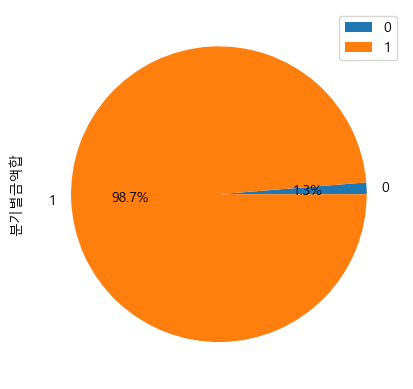

In [62]:
import matplotlib.pyplot as plt

df_b.plot(x='연속고객', y='분기별금액합', kind='pie', autopct='%1.1f%%')
plt.show()
